# Inception model explanations, t5

## First we need dataframes for every subject

In [56]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [57]:
import pandas as pd
import numpy as np
import utils
import keras

%matplotlib inline

# DEFINE GRAPH
from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

In [58]:
# Data paths
rgb_path = '../data/jpg_320_240_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 320
input_height = 180
seq_length = 10
seq_stride = 1
batch_size = 10
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 4

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [59]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [60]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [61]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_320_240_2fps/
../data/jpg_320_240_2fps/
../data/jpg_320_240_2fps/
../data/jpg_320_240_2fps/
../data/jpg_320_240_2fps/
../data/jpg_320_240_2fps/


## Now that we have frames from all subjects, we can load the model we want to test.

In [49]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_inception_4d_input_from_scratch_rmsprop_LSTMunits_None_CONVfilters_None_dense512_320x180jpg2fps_bs100_rmsprop_all_aug_v4_t5_run1_gc_rerun.h5'


In [50]:
from keras import backend as K
import tensorflow as tf

tf.reset_default_graph()
K.clear_session()
    
images = tf.placeholder(tf.float32, [batch_size, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, 2])

model = utils.InceptionNetwork(images, from_scratch=0, path=best_model_path)

Loading model...
Finished loading model. Building layers...


In [51]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

print('model preds: ', model.preds)

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)

print('cost: ', cost)

y_c = tf.reduce_sum(tf.multiply(model.dense_2, labels), axis=1)

print('y_c: ', y_c)


# target_conv_layer = model.c_86  # Choose which layer to study
# target_conv_layer = model.c_94  # Here: last conv.
target_conv_layer = model.mixed10 

print('TYPE tcl: ', type(target_conv_layer))
print('tcl: ', target_conv_layer)

target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tcl grad: ', target_conv_layer_grad)
print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_95_1/Sigmoid:0", shape=(10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(10,), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(10,), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tcl:  Tensor("mixed10_1/concat:0", shape=(10, 8, 4, 2048), dtype=float32)
tcl grad:  Tensor("gradients/global_average_pooling2d_1_1/Mean_grad/truediv:0", shape=(10, 8, 4, 2048), dtype=float32)
tclg:  Tensor("gradients/global_average_pooling2d_1_1/Mean_grad/truediv:0", shape=(10, 8, 4, 2048), dtype=float32)


In [52]:
def run_on_one_sequence(sess, model, batch_img, args):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
              feed_dict={images: batch_img,
              labels: batch_label,
              K.learning_phase(): 0})

#         print('tcl: ')
#         print(target_conv_layer_value)
#         print('')
#         print('tclg: ')
#         print(target_conv_layer_grad_value)
        
        utils.visualize_overlays(batch_img, target_conv_layer_value,
                                 target_conv_layer_grad_value, args)

# Inception predictions for subject t5

Chose subject  5
Start index in subject dataframe:  2683
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_000684.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_000685.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_000686.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_000687.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_000688.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_000689.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_000690.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_000691.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_000692.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_000693.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
tcl: 
[[[[204.5033     0.         0.       ...   0.         0.
      0.      ]
   [  0.       251.57365    0.       ...   0.         0.
      0.      ]
   [  0.       118.7441     0

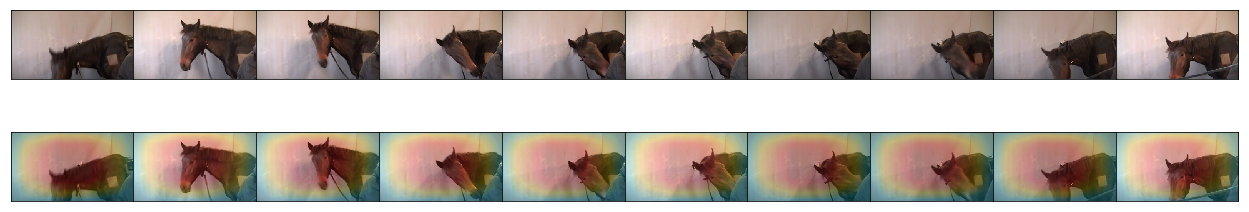

In [24]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  2262
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_000263.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_000264.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_000265.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_000266.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_000267.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_000268.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_000269.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_000270.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_000271.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_000272.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


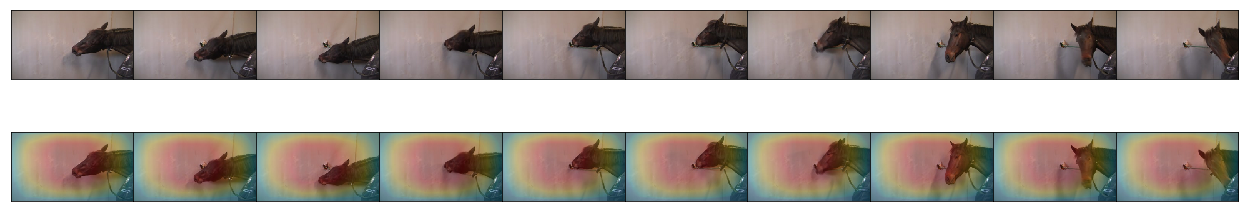

In [29]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  6247
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000854.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000855.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000856.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000857.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000858.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000859.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000860.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000861.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000862.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000863.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


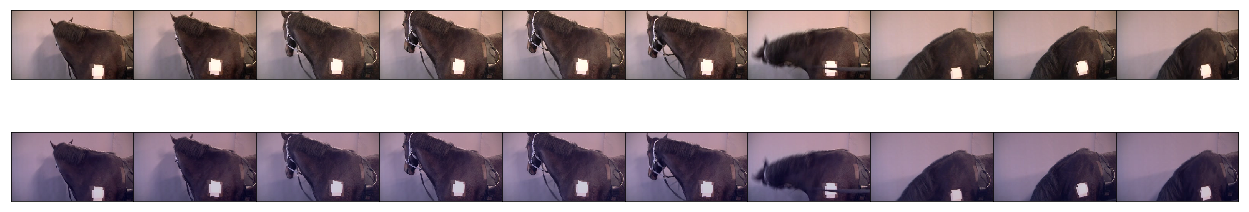

In [31]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  2290
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_000291.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_000292.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_000293.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_000294.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_000295.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_000296.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_000297.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_000298.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_000299.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_000300.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


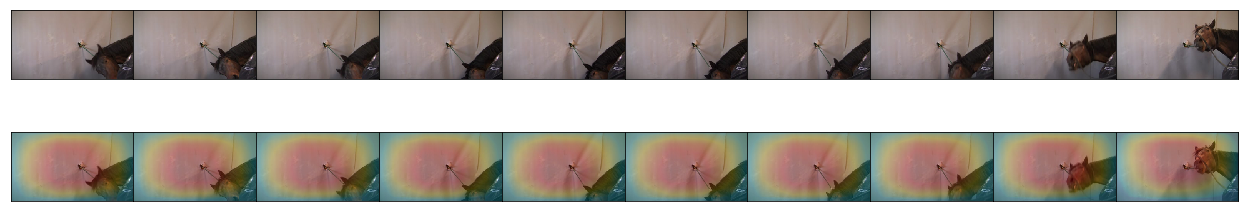

In [32]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)
batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1471
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001472.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001473.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001474.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001475.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001476.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001477.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001478.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001479.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001480.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001481.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


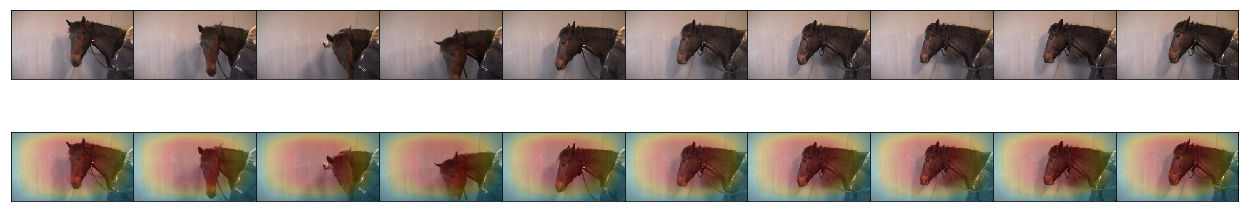

In [33]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1719
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001720.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001721.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001722.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001723.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001724.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001725.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001726.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001727.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001728.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001729.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


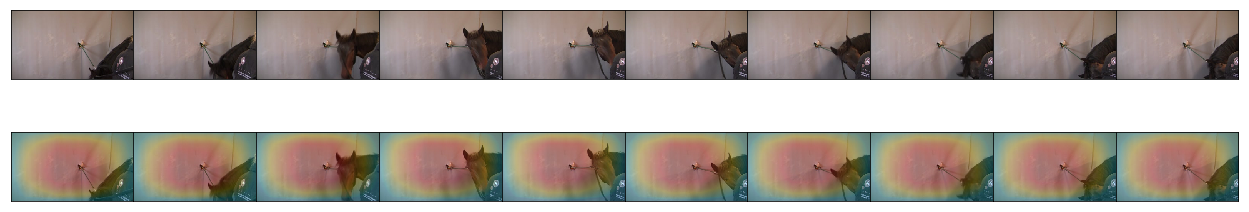

In [34]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  3663
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_4a/frame_000110.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_4a/frame_000111.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_4a/frame_000112.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_4a/frame_000113.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_4a/frame_000114.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_4a/frame_000115.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_4a/frame_000116.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_4a/frame_000117.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_4a/frame_000118.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_4a/frame_000119.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


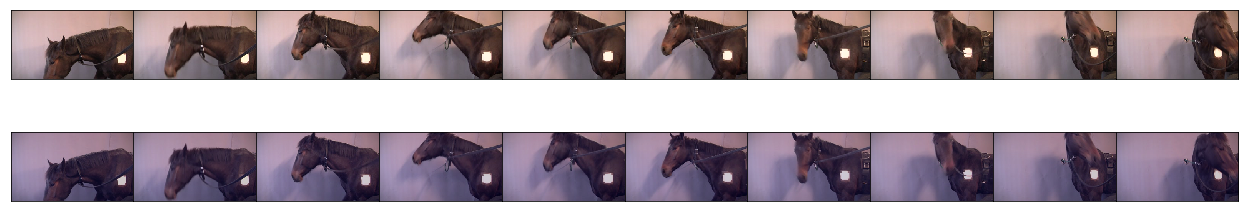

In [35]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1294
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001295.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001296.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001297.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001298.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001299.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001300.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001301.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001302.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001303.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001304.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


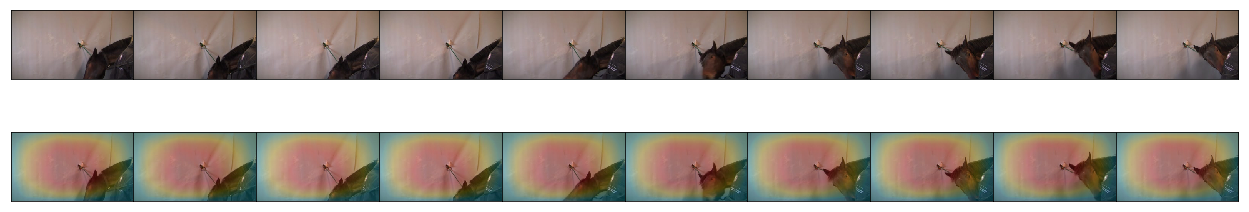

In [36]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  6468
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000175.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000176.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000177.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000178.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000179.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000180.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000181.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000182.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000183.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000184.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


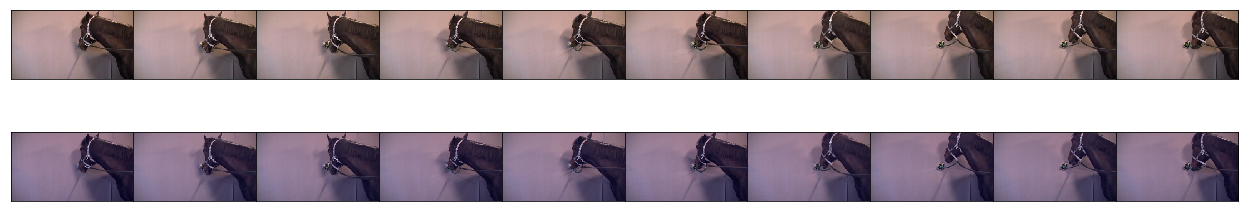

In [37]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  5772
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000379.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000380.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000381.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000382.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000383.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000384.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000385.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000386.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000387.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000388.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


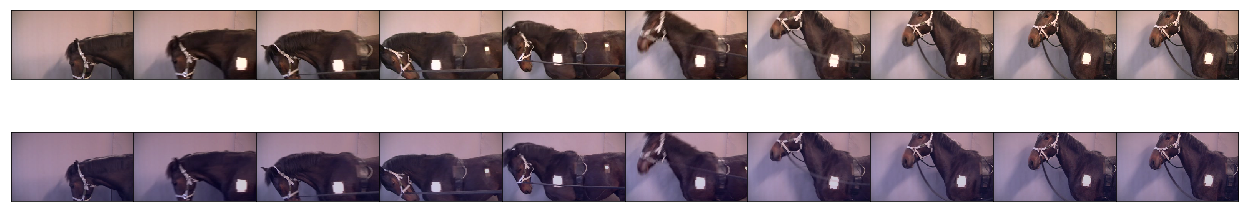

In [38]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  3774
                                                  Path  Pain
0  data/jpg_320_240_2fps/horse_6/6_4a/frame_000221.jpg     1
1  data/jpg_320_240_2fps/horse_6/6_4a/frame_000222.jpg     1
2  data/jpg_320_240_2fps/horse_6/6_4a/frame_000223.jpg     1
3  data/jpg_320_240_2fps/horse_6/6_4a/frame_000224.jpg     1
4  data/jpg_320_240_2fps/horse_6/6_4a/frame_000225.jpg     1
5  data/jpg_320_240_2fps/horse_6/6_4a/frame_000226.jpg     1
6  data/jpg_320_240_2fps/horse_6/6_4a/frame_000227.jpg     1
7  data/jpg_320_240_2fps/horse_6/6_4a/frame_000228.jpg     1
8  data/jpg_320_240_2fps/horse_6/6_4a/frame_000229.jpg     1
9  data/jpg_320_240_2fps/horse_6/6_4a/frame_000230.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


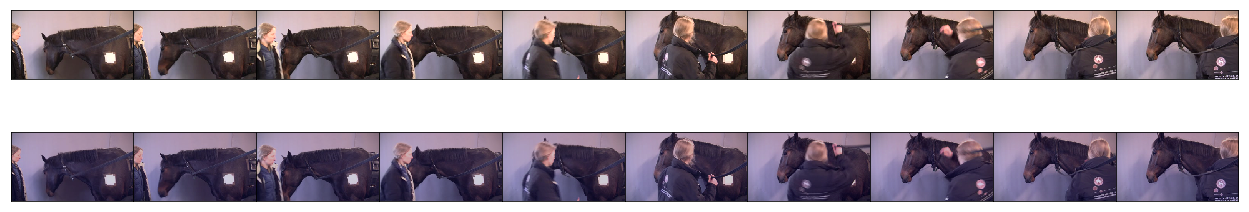

In [62]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  4882
                                                  Path  Pain
0  data/jpg_320_240_2fps/horse_6/6_4a/frame_001329.jpg     1
1  data/jpg_320_240_2fps/horse_6/6_4a/frame_001330.jpg     1
2  data/jpg_320_240_2fps/horse_6/6_4a/frame_001331.jpg     1
3  data/jpg_320_240_2fps/horse_6/6_4a/frame_001332.jpg     1
4  data/jpg_320_240_2fps/horse_6/6_4a/frame_001333.jpg     1
5  data/jpg_320_240_2fps/horse_6/6_4a/frame_001334.jpg     1
6  data/jpg_320_240_2fps/horse_6/6_4a/frame_001335.jpg     1
7  data/jpg_320_240_2fps/horse_6/6_4a/frame_001336.jpg     1
8  data/jpg_320_240_2fps/horse_6/6_4a/frame_001337.jpg     1
9  data/jpg_320_240_2fps/horse_6/6_4a/frame_001338.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


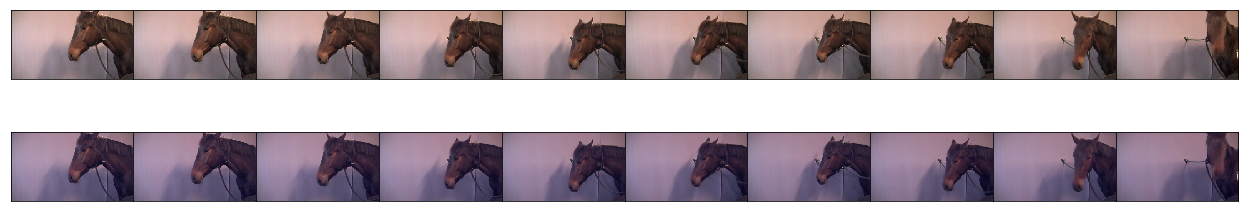

In [63]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  4343
                                                  Path  Pain
0  data/jpg_320_240_2fps/horse_6/6_4a/frame_000790.jpg     1
1  data/jpg_320_240_2fps/horse_6/6_4a/frame_000791.jpg     1
2  data/jpg_320_240_2fps/horse_6/6_4a/frame_000792.jpg     1
3  data/jpg_320_240_2fps/horse_6/6_4a/frame_000793.jpg     1
4  data/jpg_320_240_2fps/horse_6/6_4a/frame_000794.jpg     1
5  data/jpg_320_240_2fps/horse_6/6_4a/frame_000795.jpg     1
6  data/jpg_320_240_2fps/horse_6/6_4a/frame_000796.jpg     1
7  data/jpg_320_240_2fps/horse_6/6_4a/frame_000797.jpg     1
8  data/jpg_320_240_2fps/horse_6/6_4a/frame_000798.jpg     1
9  data/jpg_320_240_2fps/horse_6/6_4a/frame_000799.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


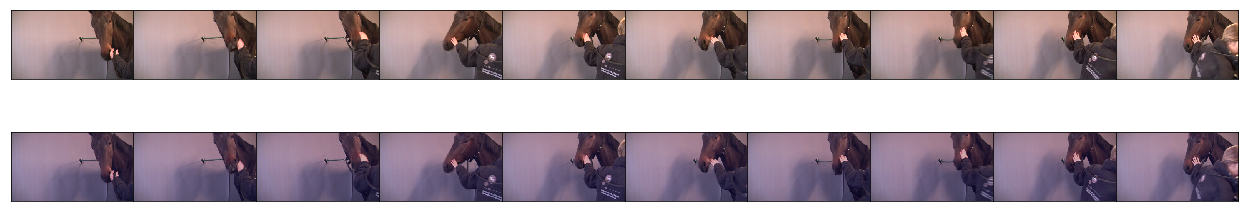

In [64]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  4471
                                                  Path  Pain
0  data/jpg_320_240_2fps/horse_6/6_4a/frame_000918.jpg     1
1  data/jpg_320_240_2fps/horse_6/6_4a/frame_000919.jpg     1
2  data/jpg_320_240_2fps/horse_6/6_4a/frame_000920.jpg     1
3  data/jpg_320_240_2fps/horse_6/6_4a/frame_000921.jpg     1
4  data/jpg_320_240_2fps/horse_6/6_4a/frame_000922.jpg     1
5  data/jpg_320_240_2fps/horse_6/6_4a/frame_000923.jpg     1
6  data/jpg_320_240_2fps/horse_6/6_4a/frame_000924.jpg     1
7  data/jpg_320_240_2fps/horse_6/6_4a/frame_000925.jpg     1
8  data/jpg_320_240_2fps/horse_6/6_4a/frame_000926.jpg     1
9  data/jpg_320_240_2fps/horse_6/6_4a/frame_000927.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


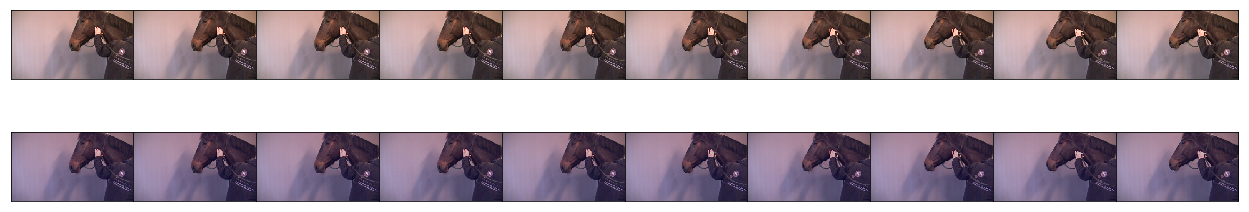

In [65]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  330
                                                  Path  Pain
0  data/jpg_320_240_2fps/horse_6/6_2a/frame_000331.jpg     0
1  data/jpg_320_240_2fps/horse_6/6_2a/frame_000332.jpg     0
2  data/jpg_320_240_2fps/horse_6/6_2a/frame_000333.jpg     0
3  data/jpg_320_240_2fps/horse_6/6_2a/frame_000334.jpg     0
4  data/jpg_320_240_2fps/horse_6/6_2a/frame_000335.jpg     0
5  data/jpg_320_240_2fps/horse_6/6_2a/frame_000336.jpg     0
6  data/jpg_320_240_2fps/horse_6/6_2a/frame_000337.jpg     0
7  data/jpg_320_240_2fps/horse_6/6_2a/frame_000338.jpg     0
8  data/jpg_320_240_2fps/horse_6/6_2a/frame_000339.jpg     0
9  data/jpg_320_240_2fps/horse_6/6_2a/frame_000340.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


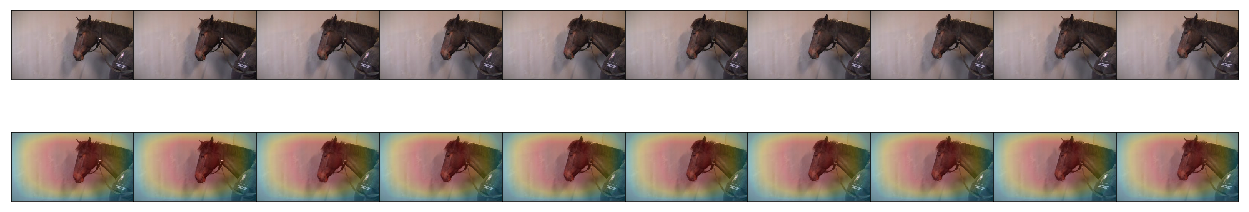

In [66]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)